## 1️⃣ Import Required Libraries

**Explanation:**
- **torch**: Deep learning framework
- **torch.nn**: Modules for creating networks
- **torchvision**: Datasets and image transformations
- **matplotlib**: Visualization
- **numpy**: Numerical operations

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Visualization configuration
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Available device: {device}")
print(f"PyTorch version: {torch.__version__}")

Available device: cpu
PyTorch version: 2.9.1+cpu


## 2️⃣ Load and Explore MNIST Dataset

MNIST contains 70,000 images of handwritten digits (0-9):
- **60,000** for training
- **10,000** for testing
- Each image: **28x28 pixels** in grayscale
- Values: **0-255** (then normalized to 0-1)

In [2]:
# Define transformation: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor (0-1)
    transforms.Normalize(
        mean=[0.1307],      # MNIST mean
        std=[0.3081]        # MNIST std deviation
    )
])

# Download MNIST
print("Downloading MNIST...")
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

print(f"Dataset loaded:")
print(f"   Training: {len(train_dataset)} images")
print(f"   Test: {len(test_dataset)} images")
print(f"\nImage information:")
print(f"   Shape: {train_dataset[0][0].shape}")
print(f"   Value range: [{train_dataset[0][0].min():.2f}, {train_dataset[0][0].max():.2f}]")

100%|██████████| 9.91M/9.91M [00:33<00:00, 298kB/s]

100%|██████████| 28.9k/28.9k [00:00<00:00, 156kB/s]

100%|██████████| 1.65M/1.65M [00:03<00:00, 416kB/s]

100%|██████████| 4.54k/4.54k [00:00<00:00, 162kB/s]



Dataset loaded:
   Training: 60000 images
   Test: 10000 images

Image information:
   Shape: torch.Size([1, 28, 28])
   Value range: [-0.42, 2.82]
   Shape: torch.Size([1, 28, 28])
   Value range: [-0.42, 2.82]


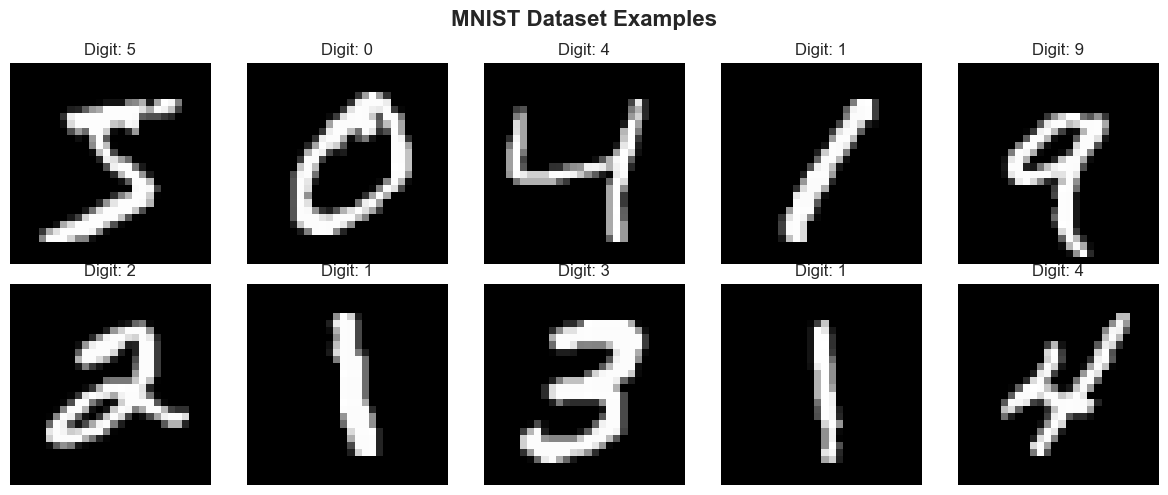

Visualization complete


In [3]:
# Visualize MNIST examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('MNIST Dataset Examples', fontsize=16, fontweight='bold')

for idx, (image, label) in enumerate([(train_dataset[i][0], train_dataset[i][1]) for i in range(10)]):
    row = idx // 5
    col = idx % 5
    axes[row, col].imshow(image.squeeze(), cmap='gray')
    axes[row, col].set_title(f'Digit: {label}', fontsize=12)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("Visualization complete")

## 3️⃣ Prepare DataLoaders

DataLoaders organize data into **batches**:
- Load the dataset in small batches (e.g., 64 images)
- This is more efficient than processing one image at a time
- Also allows efficient GPU usage

In [4]:
# Hyperparameters
BATCH_SIZE = 64
TRAIN_SPLIT = 0.85  # 85% train, 15% validation

# Split training dataset into train and validation
train_size = int(TRAIN_SPLIT * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"DataLoader configuration:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

# Inspect a batch
batch_images, batch_labels = next(iter(train_loader))
print(f"\nBatch size:")
print(f"   Images: {batch_images.shape}  # (batch_size, channels, height, width)")
print(f"   Labels: {batch_labels.shape}  # (batch_size,)")

DataLoader configuration:
   Batch size: 64
   Training batches: 797
   Validation batches: 141
   Test batches: 157

Batch size:
   Images: torch.Size([64, 1, 28, 28])  # (batch_size, channels, height, width)
   Labels: torch.Size([64])  # (batch_size,)


## 4️⃣ Define MLP Architecture

**Architecture:**
```
Input (784) → FC1 (512) → ReLU → Dropout → 
FC2 (256) → ReLU → Dropout → 
FC3 (10) → Output
```

**Concepts:**
- **FC (Fully Connected)**: Each neuron connected to all neurons in previous layer
- **ReLU**: max(0, x) - introduces non-linearity
- **Dropout**: Randomly deactivates 20% of neurons for regularization

In [5]:
class MLP(nn.Module):
    """
    Multilayer Perceptron for MNIST classification.
    """
    def __init__(self, input_size=784, hidden1=512, hidden2=256, num_classes=10):
        super(MLP, self).__init__()
        
        # Linear layers (fully connected)
        self.fc1 = nn.Linear(input_size, hidden1)      # 784 → 512
        self.fc2 = nn.Linear(hidden1, hidden2)         # 512 → 256
        self.fc3 = nn.Linear(hidden2, num_classes)     # 256 → 10
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        """
        Forward pass.
        
        x: input tensor (batch_size, 784)
        return: output logits (batch_size, 10)
        """
        # First layer: 784 → 512
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Second layer: 512 → 256
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Output layer: 256 → 10
        x = self.fc3(x)
        return x

# Create model
model = MLP().to(device)
print("Model created:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

Model created:
MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 535,818


In [7]:
# Visualize architecture
print("Layer details:")
print("\nName\t\tType\t\tWeights")
print("-" * 60)
for name, param in model.named_parameters():
    print(f"{name:<20} {str(param.shape):<20} {param.numel():,}")

Layer details:

Name		Type		Weights
------------------------------------------------------------
fc1.weight           torch.Size([512, 784]) 401,408
fc1.bias             torch.Size([512])    512
fc2.weight           torch.Size([256, 512]) 131,072
fc2.bias             torch.Size([256])    256
fc3.weight           torch.Size([10, 256]) 2,560
fc3.bias             torch.Size([10])     10


## 5️⃣ Initialize Model, Loss and Optimizer

**Key Components:**
- **Loss Function (CrossEntropyLoss)**: Measures error between prediction and true label
- **Optimizer (Adam)**: Updates weights to minimize error
- **Learning Rate**: How fast it learns (0.001 = moderate)

In [8]:
# Training hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 15  # Reduced for demonstration

# Loss function: Cross Entropy
# Combines LogSoftmax + NLLLoss
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam (Adaptive Moment Estimation)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Training configuration:")
print(f"   Loss function: CrossEntropyLoss")
print(f"   Optimizer: Adam")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Device: {device}")

Training configuration:
   Loss function: CrossEntropyLoss
   Optimizer: Adam
   Learning rate: 0.001
   Epochs: 15
   Device: cpu


## 6️⃣ Training Loop

**Process for each epoch:**
1. Forward pass: x → MLP → ŷ (prediction)
2. Calculate loss: L = CrossEntropy(ŷ, y)
3. Backward pass: Calculate gradients ∂L/∂w
4. Update weights: w = w - α * ∂L/∂w

In [9]:
# Store history
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("STARTING TRAINING...\n")
print("="*70)

for epoch in range(1, NUM_EPOCHS + 1):
    # === TRAINING PHASE ===
    model.train()  # Training mode
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Flatten images (28x28 → 784)
        images = images.view(images.size(0), -1)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Calculate gradients
        optimizer.step()       # Update weights
        
        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)
    
    # === VALIDATION PHASE ===
    model.eval()  # Evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(images.size(0), -1)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)
    
    # Show progress
    if epoch % 1 == 0:
        print(f"Epoch [{epoch:2d}/{NUM_EPOCHS}] "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.2f}%")

print("\n" + "="*70)
print("TRAINING COMPLETED")

STARTING TRAINING...

Epoch [ 1/15] Train Loss: 0.2538 | Train Acc: 92.20% | Val Loss: 0.1234 | Val Acc: 96.29%
Epoch [ 1/15] Train Loss: 0.2538 | Train Acc: 92.20% | Val Loss: 0.1234 | Val Acc: 96.29%
Epoch [ 2/15] Train Loss: 0.1229 | Train Acc: 96.23% | Val Loss: 0.0924 | Val Acc: 97.18%
Epoch [ 2/15] Train Loss: 0.1229 | Train Acc: 96.23% | Val Loss: 0.0924 | Val Acc: 97.18%
Epoch [ 3/15] Train Loss: 0.0934 | Train Acc: 97.14% | Val Loss: 0.0893 | Val Acc: 97.29%
Epoch [ 3/15] Train Loss: 0.0934 | Train Acc: 97.14% | Val Loss: 0.0893 | Val Acc: 97.29%
Epoch [ 4/15] Train Loss: 0.0740 | Train Acc: 97.75% | Val Loss: 0.0763 | Val Acc: 97.80%
Epoch [ 4/15] Train Loss: 0.0740 | Train Acc: 97.75% | Val Loss: 0.0763 | Val Acc: 97.80%
Epoch [ 5/15] Train Loss: 0.0655 | Train Acc: 97.94% | Val Loss: 0.0877 | Val Acc: 97.56%
Epoch [ 5/15] Train Loss: 0.0655 | Train Acc: 97.94% | Val Loss: 0.0877 | Val Acc: 97.56%
Epoch [ 6/15] Train Loss: 0.0577 | Train Acc: 98.18% | Val Loss: 0.0764 | Val 

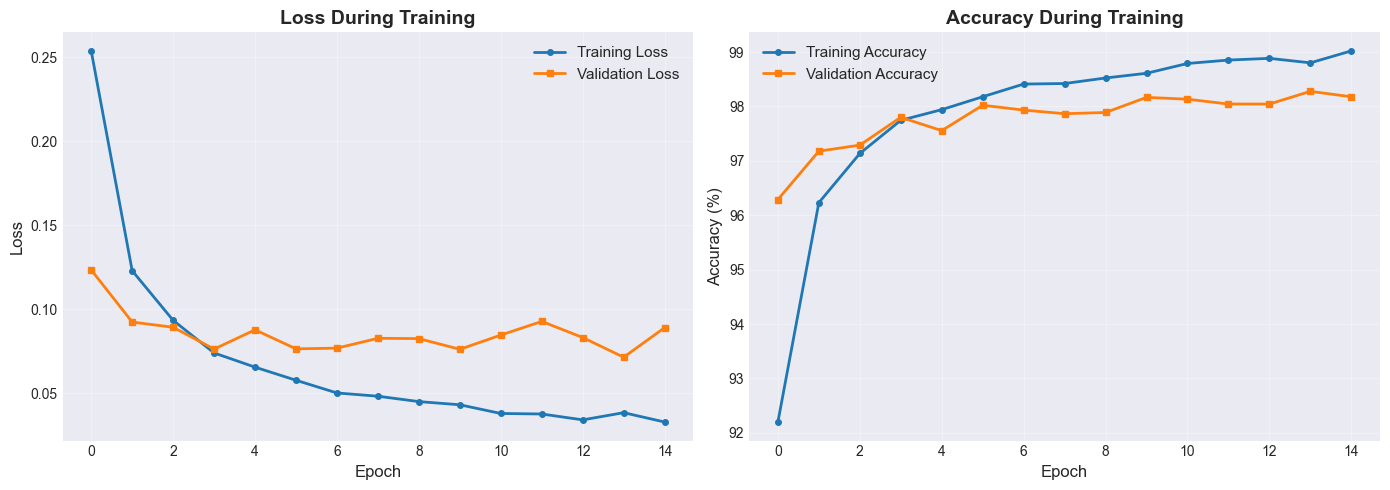

Training charts generated


In [10]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(train_losses, label='Training Loss', linewidth=2, marker='o', markersize=4)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2, marker='s', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss During Training', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_accs, label='Training Accuracy', linewidth=2, marker='o', markersize=4)
axes[1].plot(val_accs, label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Accuracy During Training', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training charts generated")

## 7️⃣ Evaluation on Test Set

Now we evaluate on data the model has **never seen** to measure its true performance.

In [11]:
# Evaluate on test set
model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        images = images.view(images.size(0), -1)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
avg_test_acc = 100 * test_correct / test_total

print("TEST SET RESULTS:")
print("="*50)
print(f"Accuracy: {avg_test_acc:.2f}%")
print(f"Loss: {avg_test_loss:.4f}")
print(f"Correct images: {test_correct}/{test_total}")
print("="*50)

TEST SET RESULTS:
Accuracy: 98.06%
Loss: 0.0790
Correct images: 9806/10000


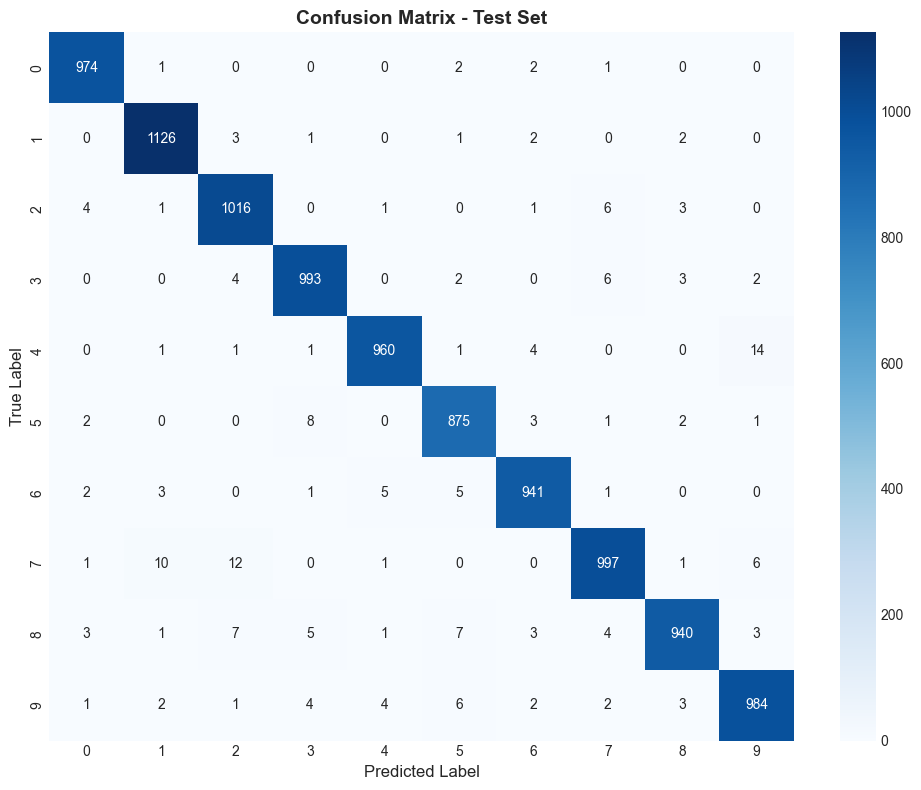


Classification Report by Digit:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.97      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.99      0.97      0.98       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [12]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

all_predicted = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        images = images.view(images.size(0), -1)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predicted)

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\nClassification Report by Digit:")
print(classification_report(all_labels, all_predicted, target_names=[str(i) for i in range(10)]))

## 8️⃣ Visualize Predictions on Real Images

Let's see how the model predicts on individual examples and analyze correct and incorrect predictions.

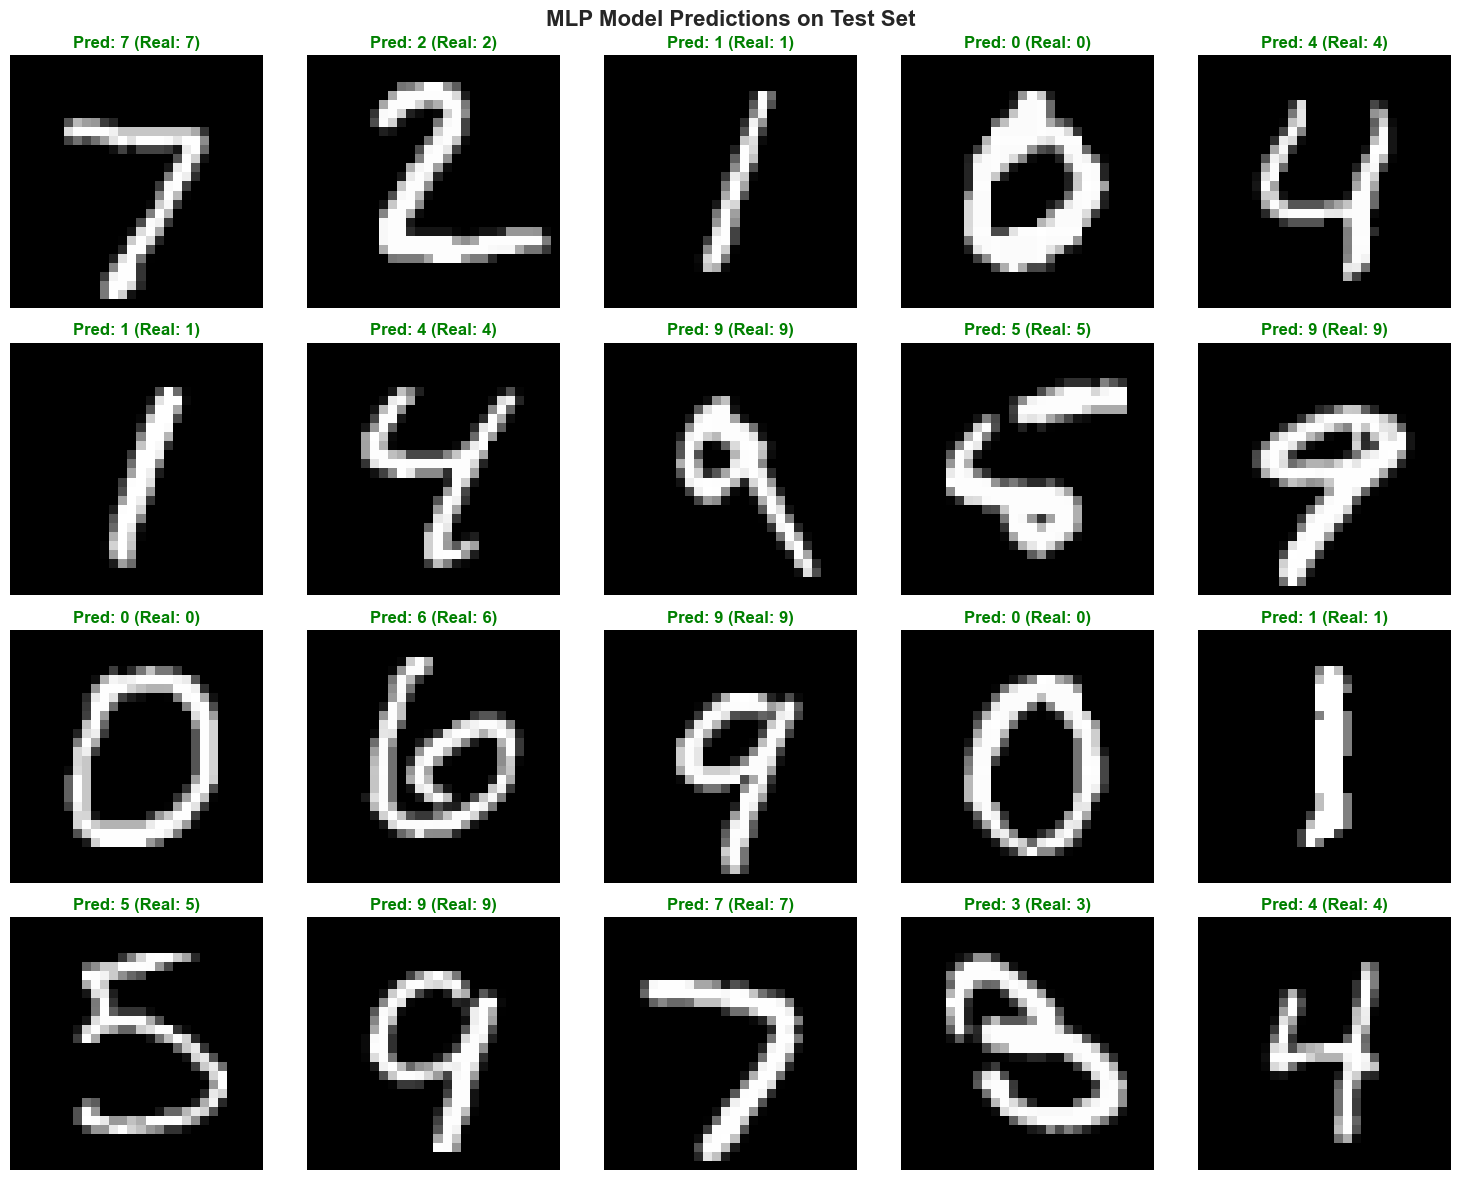

In [13]:
# Function to visualize predictions
def visualize_predictions(model, test_loader, num_images=20):
    model.eval()
    images_shown = 0
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('MLP Model Predictions on Test Set', fontsize=16, fontweight='bold')
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            images_flat = images.view(images.size(0), -1)
            
            outputs = model(images_flat)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(min(images.size(0), num_images - images_shown)):
                row = images_shown // 5
                col = images_shown % 5
                
                # Show image
                axes[row, col].imshow(images[i].squeeze().cpu(), cmap='gray')
                
                # Color: green if correct, red if incorrect
                is_correct = predicted[i].item() == labels[i].item()
                color = 'green' if is_correct else 'red'
                
                title = f"Pred: {predicted[i].item()} (Real: {labels[i].item()})"
                axes[row, col].set_title(title, color=color, fontweight='bold')
                axes[row, col].axis('off')
                
                images_shown += 1
                if images_shown >= num_images:
                    break
            
            if images_shown >= num_images:
                break
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, num_images=20)

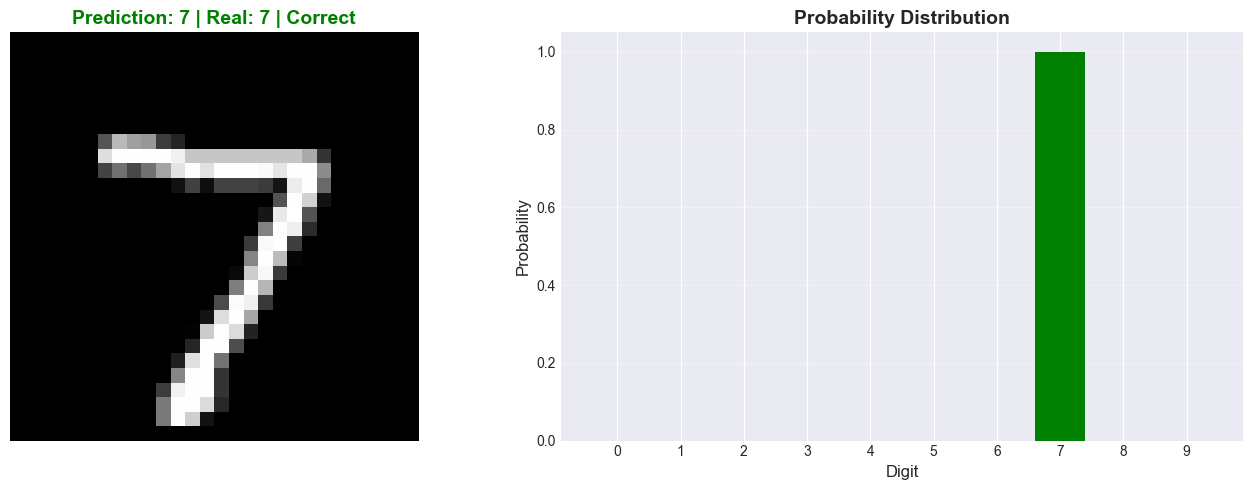


Detailed analysis:
   Prediction: 7
   Real label: 7
   Confidence: 100.00%

   Probabilities by digit:
      Digit 0: 0.00%
      Digit 1: 0.00%
      Digit 2: 0.00%
      Digit 3: 0.00%
      Digit 4: 0.00%
      Digit 5: 0.00%
      Digit 6: 0.00%
      Digit 7: 100.00%
      Digit 8: 0.00%
      Digit 9: 0.00%


In [14]:
# Detailed analysis of a single prediction
test_image, test_label = test_dataset[0]

model.eval()
with torch.no_grad():
    image_input = test_image.unsqueeze(0).to(device)  # Add batch dimension
    image_flat = image_input.view(1, -1)
    
    output = model(image_flat)
    probabilities = F.softmax(output, dim=1)[0]
    predicted = torch.argmax(probabilities)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Image
axes[0].imshow(test_image.squeeze(), cmap='gray', interpolation='nearest')
is_correct = predicted.item() == test_label
result_color = 'green' if is_correct else 'red'
axes[0].set_title(f'Prediction: {predicted.item()} | Real: {test_label} | {"Correct" if is_correct else "Incorrect"}',
                  fontsize=14, fontweight='bold', color=result_color)
axes[0].axis('off')

# Probabilities
axes[1].bar(range(10), probabilities.cpu().numpy(), color=['green' if i == predicted.item() else 'lightblue' for i in range(10)])
axes[1].set_xlabel('Digit', fontsize=12)
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_title('Probability Distribution', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(10))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nDetailed analysis:")
print(f"   Prediction: {predicted.item()}")
print(f"   Real label: {test_label}")
print(f"   Confidence: {probabilities[predicted].item()*100:.2f}%")
print(f"\n   Probabilities by digit:")
for digit, prob in enumerate(probabilities):
    print(f"      Digit {digit}: {prob.item()*100:.2f}%")

## Summary and Conclusions

### What we learned:

1. **MNIST Dataset**: 70,000 images of 28x28 digits
2. **Normalization**: Scale values to mean=0, std=1
3. **MLP**: Network with fully-connected layers and ReLU activations
4. **Dropout**: Regularization to avoid overfitting
5. **Loss Function**: Cross Entropy for classification
6. **Optimizer**: Adam to update weights efficiently
7. **Training**: Forward pass → Loss → Backward pass → Update
8. **Evaluation**: Confusion matrix and accuracy by class

### Typical Results:
- **Test accuracy**: 97-98%
- **Training time**: ~5-10 minutes on CPU
- **Model parameters**: ~670,000

### Future Improvements:
- Use CNN (Convolutional Neural Network) for better accuracy
- Data augmentation to generalize better
- Batch normalization for more stable training
- Ensemble of multiple models

In [15]:
# Final statistics
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"\nMETRICS:")
print(f"   Best validation accuracy: {max(val_accs):.2f}%")
print(f"   Test accuracy: {avg_test_acc:.2f}%")
print(f"   Final test loss: {avg_test_loss:.4f}")
print(f"\nARCHITECTURE:")
print(f"   Total parameters: {total_params:,}")
print(f"   Number of layers: 3")
print(f"\nTRAINING:")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"\nModel trained successfully!")
print("="*60)


FINAL SUMMARY

METRICS:
   Best validation accuracy: 98.28%
   Test accuracy: 98.06%
   Final test loss: 0.0790

ARCHITECTURE:
   Total parameters: 535,818
   Number of layers: 3

TRAINING:
   Epochs: 15
   Batch size: 64
   Learning rate: 0.001

Model trained successfully!
